# Kevin Ferdinand 0358519 Capstone Code


## Import Modules and Install PySpark

In [1]:
!pip list

Package                 Version
----------------------- --------
absl-py                 1.3.0
aiohttp                 3.8.3
aiosignal               1.2.0
altair                  4.1.0
anyio                   3.5.0
appdirs                 1.4.4
argon2-cffi             21.3.0
argon2-cffi-bindings    21.2.0
asttokens               2.0.5
astunparse              1.6.3
async-timeout           4.0.2
attrs                   22.1.0
autovizwidget           0.20.0
Babel                   2.11.0
backcall                0.2.0
beautifulsoup4          4.12.2
bleach                  4.1.0
blinker                 1.4
Bottleneck              1.3.5
brotlipy                0.7.0
cachetools              4.2.2
certifi                 2023.5.7
cffi                    1.15.1
charset-normalizer      2.0.4
click                   8.0.4
colorama                0.4.6
comm                    0.1.2
contourpy               1.0.5
cryptography            39.0.1
cycler                  0.11.0
debugpy                 1

In [2]:
!pip install pyspark

In [3]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['HADOOP_HOME'] = 'C:\Program Files\hadoop\hadoop-3.2.1\bin'

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from datetime import datetime

from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, StringType, FloatType
from pyspark.sql.functions import when, expr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.tree import GradientBoostedTrees
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, array, lit
from pyspark.ml import PipelineModel

import xgboost as xgb
from xgboost import plot_tree

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_iris
from sklearn.metrics import roc_curve, auc

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

## Create SparkSession and SparkContext Objects

In [6]:
spark = SparkSession.builder.master('local').appName('solution').config('spark.executor.memory', '8g').config('spark.driver.memory', '8g').getOrCreate()
sc = spark.sparkContext

In [7]:
# Jupyter Version
import os

data_dir = os.getcwd() 
data_dir = data_dir + "\\Dataset\\"
print("Current Directory:", data_dir)

Current Directory: C:\Users\kevin\Documents\CapstoneProject\CapstoneProjectTaylor\Dataset\


### Load Data as RDDs - txt to Dataframe


In [9]:
# Load Each Txt File and use spark to convert it into a Pipeline RDD
loanOriginationRDD2017 = sc.textFile(data_dir+'sample_orig_2017.txt').map(lambda x: x.split('|'))
loanOriginationRDD2018 = sc.textFile(data_dir+'sample_orig_2018.txt').map(lambda x: x.split('|'))
loanOriginationRDD2019 = sc.textFile(data_dir+'sample_orig_2019.txt').map(lambda x: x.split('|'))
loanOriginationRDD2020 = sc.textFile(data_dir+'sample_orig_2020.txt').map(lambda x: x.split('|'))

In [10]:
#loanOriginationRDD = loanOriginationRDD2017.union(loanOriginationRDD2018).union(loanOriginationRDD2019).union(loanOriginationRDD2020)
loanOriginationRDD = loanOriginationRDD2018.union(loanOriginationRDD2019).union(loanOriginationRDD2020)

In [11]:
monthlyPerformanceRDD2017 = sc.textFile(data_dir+'sample_svcg_2017.txt').map(lambda x: x.split('|'))
monthlyPerformanceRDD2018 = sc.textFile(data_dir+'sample_svcg_2018.txt').map(lambda x: x.split('|'))
monthlyPerformanceRDD2019 = sc.textFile(data_dir+'sample_svcg_2019.txt').map(lambda x: x.split('|'))
monthlyPerformanceRDD2020 = sc.textFile(data_dir+'sample_svcg_2020.txt').map(lambda x: x.split('|'))

#monthlyPerformanceRDD = monthlyPerformanceRDD2017.union(monthlyPerformanceRDD2018).union(monthlyPerformanceRDD2019).union(monthlyPerformanceRDD2020)
monthlyPerformanceRDD = monthlyPerformanceRDD2018.union(monthlyPerformanceRDD2019).union(monthlyPerformanceRDD2020)


### Check Content

In [12]:
print('There are', loanOriginationRDD.count(), 'records in the loan origination dataset.')
print('There are', monthlyPerformanceRDD.count(), 'records in the monthly performance dataset.')

There are 150000 records in the loan origination dataset.
There are 3943964 records in the monthly performance dataset.


## Convert it into DataFrame

In [13]:
# Create the Loan Origination DataFrame from the Loan Origination RDD.
# Next, assign new column names to that DataFrame.

loanOriginationDF = spark.createDataFrame(loanOriginationRDD).toDF(
    'CREDIT_SCORE', 
    'FIRST_PAYMENT_DATE',
    'FIRST_TIME_HOMEBUYER_FLAG',
    'MATURITY_DATE',
    'METROPOLITAN_STATISTICAL_AREA',
    'MORTGAGE_INSURANCE_PERCENTAGE',
    'NUMBER_OF_UNITS',
    'OCCUPANCY_STATUS',
    'ORIGINAL_COMBINED_LOAN_TO_VALUE',
    'ORIGINAL_DEBT_TO_INCOME_RATIO',
    'ORIGINAL_UPB',
    'ORIGINAL_LOAN_TO_VALUE',
    'ORIGINAL_INTEREST_RATE',
    'CHANNEL',
    'PREPAYMENT_PENALTY_MORTGAGE_FLAG',
    'AMORTIZATION_TYPE',
    'PROPERTY_STATE',
    'PROPERTY_TYPE',
    'POSTAL_CODE',
    'LOAN_SEQUENCE_NUMBER',
    'LOAN_PURPOSE',
    'ORIGINAL_LOAN_TERM',
    'NUMBER_OF_BORROWERS',
    'SELLER_NAME',
    'SERVICER_NAME',
    'SUPER_CONFORMING_FLAG',
    'PRERELIEF_REFINANCE_LOAN_SEQUENCE_NUMBER',
    'PROGRAM_INDICATOR',
    'RELIEF_REFINANCE_INDICATOR',
    'PROPERTY_VALUATION_METHOD',
    'INTEREST_ONLY_INDICATOR')

### Extract DELINQUENT from Monthly Performance RDD

In [14]:
dictionary = {}
# Txt File states that 0 = no delinquency , 1 = have a delinquent 
# Extract these coreesponding to the Loan Sequence Number and check if there is any instance of delinquency
def fillDictionary(record):
    loanSequenceNumber = record[0]
    currentLoanDelinquencyStatus = record[3]
    delinquent = 0 if currentLoanDelinquencyStatus == '0' else 1
    if loanSequenceNumber in dictionary:
        if dictionary[loanSequenceNumber] == 0:
            dictionary[loanSequenceNumber] = delinquent
    else:
        dictionary[loanSequenceNumber] = delinquent

monthlyPerformanceData = monthlyPerformanceRDD.collect()

for record in monthlyPerformanceData:
    fillDictionary(record)
print('The dictionary contains', len(dictionary), 'key-value pairs.')

The dictionary contains 149997 key-value pairs.


### Create Delinquent DataFrame

In [15]:
delinquentDF = spark.createDataFrame(dictionary.items(), schema=['LOAN_SEQUENCE_NUMBER', 'DELINQUENT'])
delinquentDF.printSchema()

root
 |-- LOAN_SEQUENCE_NUMBER: string (nullable = true)
 |-- DELINQUENT: long (nullable = true)



Now Join them with the other file to get a pair of person data and delinquency

In [16]:
df = loanOriginationDF.join(delinquentDF, 'LOAN_SEQUENCE_NUMBER')  # inner join
#df.printSchema()

loanInDelinquencyCount = df.filter(df['DELINQUENT'] == 1).count()
loanNotInDelinquencyCount = df.filter(df['DELINQUENT'] == 0).count()
loanCount = loanInDelinquencyCount + loanNotInDelinquencyCount

print('There are', loanInDelinquencyCount, 'loans in delinquency.')
print('There are', loanNotInDelinquencyCount, 'loans not in delinquency.')
print('There are', loanCount, 'available loans in total.')

There are 14830 loans in delinquency.
There are 135167 loans not in delinquency.
There are 149997 available loans in total.


### Drop Columns that is not important

In [17]:
#print(df.select(df['AMORTIZATION_TYPE']).distinct().collect())  # one distinct value - drop the column!

columnsToDrop = [
    'FIRST_PAYMENT_DATE',
    'MATURITY_DATE',
    'MORTGAGE_INSURANCE_PERCENTAGE',
    'ORIGINAL_UPB',
    'PREPAYMENT_PENALTY_MORTGAGE_FLAG',
    'PROPERTY_STATE',
    'LOAN_SEQUENCE_NUMBER',
    'SELLER_NAME',
    'SERVICER_NAME',
    'SUPER_CONFORMING_FLAG',
    'PRERELIEF_REFINANCE_LOAN_SEQUENCE_NUMBER',
    'PROGRAM_INDICATOR',
    'RELIEF_REFINANCE_INDICATOR',
    'PROPERTY_VALUATION_METHOD',
    'INTEREST_ONLY_INDICATOR',
    'AMORTIZATION_TYPE'
]

df = df.drop(*columnsToDrop)

In [18]:
# Check Datatypes
df.printSchema()


root
 |-- CREDIT_SCORE: string (nullable = true)
 |-- FIRST_TIME_HOMEBUYER_FLAG: string (nullable = true)
 |-- METROPOLITAN_STATISTICAL_AREA: string (nullable = true)
 |-- NUMBER_OF_UNITS: string (nullable = true)
 |-- OCCUPANCY_STATUS: string (nullable = true)
 |-- ORIGINAL_COMBINED_LOAN_TO_VALUE: string (nullable = true)
 |-- ORIGINAL_DEBT_TO_INCOME_RATIO: string (nullable = true)
 |-- ORIGINAL_LOAN_TO_VALUE: string (nullable = true)
 |-- ORIGINAL_INTEREST_RATE: string (nullable = true)
 |-- CHANNEL: string (nullable = true)
 |-- PROPERTY_TYPE: string (nullable = true)
 |-- POSTAL_CODE: string (nullable = true)
 |-- LOAN_PURPOSE: string (nullable = true)
 |-- ORIGINAL_LOAN_TERM: string (nullable = true)
 |-- NUMBER_OF_BORROWERS: string (nullable = true)
 |-- DELINQUENT: long (nullable = true)



Change some Datatypes to Double

In [19]:
df = df.withColumn('CREDIT_SCORE', df['CREDIT_SCORE'].cast(DoubleType()))
df = df.withColumn('METROPOLITAN_STATISTICAL_AREA', df['METROPOLITAN_STATISTICAL_AREA'].cast(DoubleType()))
df = df.withColumn('NUMBER_OF_UNITS', df['NUMBER_OF_UNITS'].cast(DoubleType()))
df = df.withColumn('ORIGINAL_COMBINED_LOAN_TO_VALUE', df['ORIGINAL_COMBINED_LOAN_TO_VALUE'].cast(DoubleType()))
df = df.withColumn('ORIGINAL_DEBT_TO_INCOME_RATIO', df['ORIGINAL_DEBT_TO_INCOME_RATIO'].cast(DoubleType()))
df = df.withColumn('ORIGINAL_LOAN_TO_VALUE', df['ORIGINAL_LOAN_TO_VALUE'].cast(DoubleType()))
df = df.withColumn('POSTAL_CODE', df['POSTAL_CODE'].cast(DoubleType()))
df = df.withColumn('ORIGINAL_LOAN_TERM', df['ORIGINAL_LOAN_TERM'].cast(DoubleType()))
df = df.withColumn('NUMBER_OF_BORROWERS', df['NUMBER_OF_BORROWERS'].cast(DoubleType()))
df = df.withColumn('ORIGINAL_INTEREST_RATE', df['ORIGINAL_INTEREST_RATE'].cast(DoubleType()))
df.printSchema()

root
 |-- CREDIT_SCORE: double (nullable = true)
 |-- FIRST_TIME_HOMEBUYER_FLAG: string (nullable = true)
 |-- METROPOLITAN_STATISTICAL_AREA: double (nullable = true)
 |-- NUMBER_OF_UNITS: double (nullable = true)
 |-- OCCUPANCY_STATUS: string (nullable = true)
 |-- ORIGINAL_COMBINED_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_DEBT_TO_INCOME_RATIO: double (nullable = true)
 |-- ORIGINAL_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_INTEREST_RATE: double (nullable = true)
 |-- CHANNEL: string (nullable = true)
 |-- PROPERTY_TYPE: string (nullable = true)
 |-- POSTAL_CODE: double (nullable = true)
 |-- LOAN_PURPOSE: string (nullable = true)
 |-- ORIGINAL_LOAN_TERM: double (nullable = true)
 |-- NUMBER_OF_BORROWERS: double (nullable = true)
 |-- DELINQUENT: long (nullable = true)



### Make 2 functions to help analyze categorical and continuos data

In [21]:
# Analyse categorical features.
# the Dataframe with Selected Attributes, Selected Column Name , The Figure Size, Title , Rotation
def analyseCategoricalData(df, column, fig_size=(12, 7), title=None, rot=90):
    # Print Unique Values and Missing Values 
    print("Number of unique values: {}\n".format(len(df[column].unique())))
    print("Number of missing values: {}\n".format(df[column].isnull().sum()))
    # Count the Missing Values
    df = np.round(df[column].value_counts(normalize=True, ascending=False, dropna=False) * 100, 2)
    if True in df.index.isnull():
        df.index = df.index.fillna("Missing Values") 
    print(df)
    # Plot the Figure using pyplot 
    fig = plt.figure(figsize=fig_size)
    ax = df.plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.title(title)
    plt.xticks(rotation=rot)
    plt.savefig(column + '.png', dpi=fig.dpi)
    plt.show()

def analyseContinuousData(df, column, xlabel="", figSize=(12, 7)):
    # Print Missing Values and Statistics such as Mean, std,count ....
    print("Number of missing values: {}\n".format(df[column].isnull().sum()))
    print('Descriptive statistics:\n')
    print(df[column].describe())

    # Plot the graphs Make it as density values to better represent it
    fig, ax = plt.subplots()
    df.loc[df.DELINQUENT == True, column].plot.hist(bins=50, density=True, ax=ax, alpha=0.4, label='Delinquent')
    df.loc[df.DELINQUENT == False, column].plot.hist(bins=50, density=True, ax=ax, alpha=0.4, label='Non-Delinquent')
    plt.title("Delinquent vs. Non-Delinquent")
    plt.xlabel(xlabel)
    plt.ylabel('Density Value')
    plt.legend()
    plt.savefig(column + '.png', dpi=fig.dpi)
    plt.show()

## Exploratory Data Analysis

### Explore CREDIT_SCORE

In [22]:
# A credit score is unavailable when its value is 9999.
print('The number of loan records with unavailable credit scores:', df.filter(df['CREDIT_SCORE'] == 9999).count())

The number of loan records with unavailable credit scores: 40


In [23]:
# Replace the values of unavailable credit scores with None.
df = df.withColumn('CREDIT_SCORE', when(df['CREDIT_SCORE'] != 9999, df['CREDIT_SCORE']).otherwise(None))

In [24]:
# Replace the values of unavailable credit scores with 0.
df = df.withColumn('CREDIT_SCORE', when(df['CREDIT_SCORE'].isNotNull(), df['CREDIT_SCORE']).otherwise(0.0))
print('The number of loan records with unavailable credit scores:', df.filter(df['CREDIT_SCORE'] == 0.0).count())

The number of loan records with unavailable credit scores: 40


### Explore First Time Homebuyer Flag

In [25]:
# A first-time homebuyer flag is unavailable when its value is '9'.

print('The number of loan records with unavailable first-time homebuyer flags:', df.filter(df['FIRST_TIME_HOMEBUYER_FLAG'] == '9').count())

The number of loan records with unavailable first-time homebuyer flags: 0


### Explore Original Interest Rate

In [26]:

print('Number of loan records with unavailable ORIGINAL_INTEREST_RATE:', df.filter(df['ORIGINAL_INTEREST_RATE'].isNull()).count())

Number of loan records with unavailable ORIGINAL_INTEREST_RATE: 0


Number of missing values: 0

Descriptive statistics:

count    149997.000000
mean          4.055072
std           0.831855
min           0.000000
25%           3.375000
50%           4.125000
75%           4.750000
max           6.750000
Name: ORIGINAL_INTEREST_RATE, dtype: float64


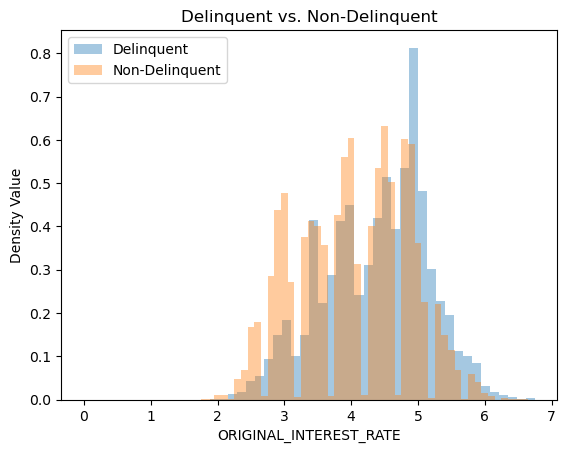

In [27]:
# Analyse the ORIGINAL_INTEREST_RATE column.

pandasDF = df.select(df['ORIGINAL_INTEREST_RATE'], df['DELINQUENT']).toPandas()
analyseContinuousData(pandasDF, column='ORIGINAL_INTEREST_RATE', xlabel='ORIGINAL_INTEREST_RATE')


### Explore METROPOLITAN_STATISTICAL_AREA


In [28]:
# MSA is codes that corresponds to a certain area and have some information about them
print('Number of unique MSA codes:', df.select(df['METROPOLITAN_STATISTICAL_AREA']).distinct().count())
print('Number of loan records with unavailable MSA codes:', df.filter(df['METROPOLITAN_STATISTICAL_AREA'].isNull()).count())

Number of unique MSA codes: 415
Number of loan records with unavailable MSA codes: 13731


replace null with 0 and keep non null as usuall


In [29]:
df = df.withColumn('METROPOLITAN_STATISTICAL_AREA', when(df['METROPOLITAN_STATISTICAL_AREA'].isNotNull(), df['METROPOLITAN_STATISTICAL_AREA']).otherwise(0.0))

### Explore NUMBER_OF_UNITS

In [30]:
# The number of units is unavailable when its value is 99.

print('The number of loan records with the unavailable number of units:', df.filter(df['NUMBER_OF_UNITS'] == 99).count())

The number of loan records with the unavailable number of units: 0


### Explore OCCUPANCY_STATUS

In [31]:
# An occupancy status is unavailable when its value is '9'.

print('The number of loan records with unavailable occupancy status:', df.filter(df['OCCUPANCY_STATUS'] == '9').count())

The number of loan records with unavailable occupancy status: 0


### Explore ORIGINAL_COMBINED_LOAN_TO_VALUE of property


In [32]:
# An original combined LTV is unavailable when its value is 999.

print('The number of loan records with unavailable original combined LTVs:', df.filter(df['ORIGINAL_COMBINED_LOAN_TO_VALUE'] == 999).count())

The number of loan records with unavailable original combined LTVs: 4


In [33]:
# Replace unavailable values with None for the EDA

df = df.withColumn('ORIGINAL_COMBINED_LOAN_TO_VALUE', when(df['ORIGINAL_COMBINED_LOAN_TO_VALUE'] != 999, df['ORIGINAL_COMBINED_LOAN_TO_VALUE']).otherwise(None))

In [34]:
# Replace the missing values with the median for training

df = df.withColumn('ORIGINAL_COMBINED_LOAN_TO_VALUE', when(df['ORIGINAL_COMBINED_LOAN_TO_VALUE'].isNotNull(), df['ORIGINAL_COMBINED_LOAN_TO_VALUE']).otherwise(80))

### Explore ORIGINAL_DEBT_TO_INCOME_RATIO

In [35]:
# ORIGINAL_DEBT_TO_INCOME_RATIO is unavailable when its value is 999.

print('The number of loan records with unavailable original DTIR:', df.filter(df['ORIGINAL_DEBT_TO_INCOME_RATIO'] == 999).count())

The number of loan records with unavailable original DTIR: 604


In [36]:
# Replace unavailable values with Mean.

df = df \
.withColumn('ORIGINAL_DEBT_TO_INCOME_RATIO', when(df['ORIGINAL_DEBT_TO_INCOME_RATIO'] != 999, df['ORIGINAL_DEBT_TO_INCOME_RATIO']).otherwise(35))

### Explore ORIGINAL_LOAN_TO_VALUE of the property

In [37]:
# An original LTV is unavailable when its value is 999.

print('The number of loan records with unavailable original LTVs:', df.filter(df['ORIGINAL_LOAN_TO_VALUE'] == 999).count())

The number of loan records with unavailable original LTVs: 1


In [38]:
# Replace unavailable values with None.

df = df.withColumn('ORIGINAL_LOAN_TO_VALUE', when(df['ORIGINAL_LOAN_TO_VALUE'] != 999, df['ORIGINAL_LOAN_TO_VALUE']).otherwise(None))

In [39]:
# Replace  the missing values with the median.

df = df.withColumn('ORIGINAL_LOAN_TO_VALUE', when(df['ORIGINAL_LOAN_TO_VALUE'].isNotNull(), df['ORIGINAL_LOAN_TO_VALUE']).otherwise(80))

In [40]:
# Replace mIssing with mean of 327
df = df.withColumn('ORIGINAL_LOAN_TERM', when(df['ORIGINAL_LOAN_TERM'].isNotNull(), df['ORIGINAL_LOAN_TERM']).otherwise(327))

In [41]:
df.printSchema()

root
 |-- CREDIT_SCORE: double (nullable = true)
 |-- FIRST_TIME_HOMEBUYER_FLAG: string (nullable = true)
 |-- METROPOLITAN_STATISTICAL_AREA: double (nullable = true)
 |-- NUMBER_OF_UNITS: double (nullable = true)
 |-- OCCUPANCY_STATUS: string (nullable = true)
 |-- ORIGINAL_COMBINED_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_DEBT_TO_INCOME_RATIO: double (nullable = true)
 |-- ORIGINAL_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_INTEREST_RATE: double (nullable = true)
 |-- CHANNEL: string (nullable = true)
 |-- PROPERTY_TYPE: string (nullable = true)
 |-- POSTAL_CODE: double (nullable = true)
 |-- LOAN_PURPOSE: string (nullable = true)
 |-- ORIGINAL_LOAN_TERM: double (nullable = true)
 |-- NUMBER_OF_BORROWERS: double (nullable = true)
 |-- DELINQUENT: long (nullable = true)



### Check amount of Denlinquents and Non Delinquents, OverSampling

In [42]:
df.count()

149997

In [43]:
#stop

In [44]:
# Split the dataframe into positive (DELINQUENT = 1) and negative (DELINQUENT = 0) examples
positive_df = df.filter(col("DELINQUENT") == 1)
negative_df = df.filter(col("DELINQUENT") == 0)

In [45]:
print(positive_df.count())
print(negative_df.count())

14830
135167


In [46]:
# Calculate the ratio of positive to negative examples
positive_count = positive_df.count()
negative_count = negative_df.count()
oversample_ratio = negative_count / positive_count
print(oversample_ratio)


9.114430209035739


In [47]:
# there is a high ratio of positive to negative, but for this scenario 2 should be enough
oversample_ratio = 2.0
# Oversample the positive examples
oversampled_positive_df = positive_df.sample(withReplacement=True, fraction=oversample_ratio, seed=42)

# Combine the oversampled positive examples with the original negative examples
balanced_df = negative_df.unionAll(oversampled_positive_df)


In [48]:
oversampled_positive_df.count()

29516

In [49]:
balanced_df.count()

164683

In [50]:
balanced_df.printSchema()

root
 |-- CREDIT_SCORE: double (nullable = true)
 |-- FIRST_TIME_HOMEBUYER_FLAG: string (nullable = true)
 |-- METROPOLITAN_STATISTICAL_AREA: double (nullable = true)
 |-- NUMBER_OF_UNITS: double (nullable = true)
 |-- OCCUPANCY_STATUS: string (nullable = true)
 |-- ORIGINAL_COMBINED_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_DEBT_TO_INCOME_RATIO: double (nullable = true)
 |-- ORIGINAL_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_INTEREST_RATE: double (nullable = true)
 |-- CHANNEL: string (nullable = true)
 |-- PROPERTY_TYPE: string (nullable = true)
 |-- POSTAL_CODE: double (nullable = true)
 |-- LOAN_PURPOSE: string (nullable = true)
 |-- ORIGINAL_LOAN_TERM: double (nullable = true)
 |-- NUMBER_OF_BORROWERS: double (nullable = true)
 |-- DELINQUENT: long (nullable = true)



## Train a Gradient Boosting Decision Tree Model - Preparing Data

In [51]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [52]:
# make one-hot encoding for string categorical features
categorical_features = [
    'FIRST_TIME_HOMEBUYER_FLAG',
    'LOAN_PURPOSE',
    'NUMBER_OF_UNITS',
    'OCCUPANCY_STATUS',
    'CHANNEL',
    'PROPERTY_TYPE'
]

out_categorical_index_features = ['INDEX_FIRST_TIME_HOMEBUYER_FLAG',
                                  'INDEX_LOAN_PURPOSE',
                                  'INDEX_NUMBER_OF_UNITS',
                                  'INDEX_OCCUPANCY_STATUS',
                                  'INDEX_CHANNEL',
                                  'INDEX_PROPERTY_TYPE'
                                  ]

out_categorical_onehot_features = ['FIRST_TIME_HOMEBUYER_FLAG_VEC',
                                   'LOAN_PURPOSE_VEC',
                                   'NUMBER_OF_UNITS_VEC',
                                   'OCCUPANCY_STATUS_VEC',
                                   'CHANNEL_VEC',
                                   'PROPERTY_TYPE_VEC'
                                   ]


In [53]:
# Change Categorical Values into Numeric Values by changing into String Index then OneHot

string_encoder = StringIndexer()
string_encoder.setInputCols(categorical_features)
string_encoder.setOutputCols(out_categorical_index_features)
indexed_df = string_encoder.fit(balanced_df).transform(balanced_df)
indexed_df = indexed_df.drop(*categorical_features)

onehot_encoder = OneHotEncoder()
onehot_encoder.setInputCols(out_categorical_index_features)
onehot_encoder.setOutputCols(out_categorical_onehot_features)
encoded_df = onehot_encoder.fit(indexed_df).transform(indexed_df)
encoded_df = encoded_df.drop(*out_categorical_index_features)



In [54]:
encoded_df.printSchema()

root
 |-- CREDIT_SCORE: double (nullable = true)
 |-- METROPOLITAN_STATISTICAL_AREA: double (nullable = true)
 |-- ORIGINAL_COMBINED_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_DEBT_TO_INCOME_RATIO: double (nullable = true)
 |-- ORIGINAL_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_INTEREST_RATE: double (nullable = true)
 |-- POSTAL_CODE: double (nullable = true)
 |-- ORIGINAL_LOAN_TERM: double (nullable = true)
 |-- NUMBER_OF_BORROWERS: double (nullable = true)
 |-- DELINQUENT: long (nullable = true)
 |-- FIRST_TIME_HOMEBUYER_FLAG_VEC: vector (nullable = true)
 |-- LOAN_PURPOSE_VEC: vector (nullable = true)
 |-- NUMBER_OF_UNITS_VEC: vector (nullable = true)
 |-- OCCUPANCY_STATUS_VEC: vector (nullable = true)
 |-- CHANNEL_VEC: vector (nullable = true)
 |-- PROPERTY_TYPE_VEC: vector (nullable = true)



### Since PySpark have problems, Change to Pandas Dataframe to use with XGBoost

In [55]:
pandas_df = balanced_df.toPandas()

In [56]:
shape = pandas_df.shape
print("shape:", shape)

shape: (164683, 16)


In [57]:
schema = pandas_df.dtypes
print(schema)

CREDIT_SCORE                       float64
FIRST_TIME_HOMEBUYER_FLAG           object
METROPOLITAN_STATISTICAL_AREA      float64
NUMBER_OF_UNITS                    float64
OCCUPANCY_STATUS                    object
ORIGINAL_COMBINED_LOAN_TO_VALUE    float64
ORIGINAL_DEBT_TO_INCOME_RATIO      float64
ORIGINAL_LOAN_TO_VALUE             float64
ORIGINAL_INTEREST_RATE             float64
CHANNEL                             object
PROPERTY_TYPE                       object
POSTAL_CODE                        float64
LOAN_PURPOSE                        object
ORIGINAL_LOAN_TERM                 float64
NUMBER_OF_BORROWERS                float64
DELINQUENT                           int64
dtype: object


In [58]:
null_columns = pandas_df.columns[pandas_df.isnull().any()]
if null_columns.empty:
    print("No null values found in any column.")
else:
    print("Null values found in the following columns:")
    for col in null_columns:
        print(col)

No null values found in any column.


In [59]:
mappings = {}
# Label Encode And Save the Label Encoder 
label_encoder = LabelEncoder()
categorical_cols = ["FIRST_TIME_HOMEBUYER_FLAG", "OCCUPANCY_STATUS", "CHANNEL", "PROPERTY_TYPE", "LOAN_PURPOSE"]
for col in categorical_cols:
    pandas_df[col] = label_encoder.fit_transform(pandas_df[col])
    # Create a mapping dictionary
    mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

    # Save the mapping dictionary to a CSV file
    mapping_df = pd.DataFrame.from_dict(mapping, orient='index', columns=[col])
    mapping_df.to_csv(f"{col}_mapping.csv", index_label='Encoded_Value')

    # Store the mapping dictionary in the mappings dictionary
    mappings[col] = mapping
    
    joblib.dump(label_encoder, f"{col}_mapping.joblib")
    

### Test the Label Encoder

In [60]:
# Sample data
data = [
    [450, 'N', 12345.0, 1, 'I', 74,20,10,2, 'R', 'SF', 54321.0, 'P', 360.0, 1.0],
    [200, 'Y', 23456.0, 2, 'P', 115,30, 100,3, 'C', 'CO', 65432.0, 'N', 240.0, 2.0],
    [650, 'N', 34567.0, 1, 'S', 100,40, 30,4, 'B', 'CP', 76543.0, 'C', 180.0, 1.0],
    [500, 'Y', 45678.0, 2, 'I', 50,50, 40, 5,'B', 'MH', 87654.0, 'C', 300.0, 3.0],
    [500, 'Y', 47664.0, 2, 'P', 69,10, 69,6, 'C', 'SF', 48300.0, 'N', 240.0, 1.0],
]

In [61]:
# Column names based on the given schema
columns = [
    'CREDIT_SCORE',
    'FIRST_TIME_HOMEBUYER_FLAG',
    'METROPOLITAN_STATISTICAL_AREA',
    'NUMBER_OF_UNITS', 
    'OCCUPANCY_STATUS',
    'ORIGINAL_COMBINED_LOAN_TO_VALUE',
    'ORIGINAL_DEBT_TO_INCOME_RATIO',
    'ORIGINAL_LOAN_TO_VALUE',
    'ORIGINAL_INTEREST_RATE',
    'CHANNEL',
    'PROPERTY_TYPE',
    'POSTAL_CODE',
    'LOAN_PURPOSE',
    'ORIGINAL_LOAN_TERM',
    'NUMBER_OF_BORROWERS',
    
]
test_DF = pd.DataFrame(data, columns=columns)

In [62]:
test_DF

,CREDIT_SCORE,FIRST_TIME_HOMEBUYER_FLAG,METROPOLITAN_STATISTICAL_AREA,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PROPERTY_TYPE,POSTAL_CODE,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS
0,450,N,12345.0,1,I,74,20,10,2,R,SF,54321.0,P,360.0,1.0
1,200,Y,23456.0,2,P,115,30,100,3,C,CO,65432.0,N,240.0,2.0
2,650,N,34567.0,1,S,100,40,30,4,B,CP,76543.0,C,180.0,1.0
3,500,Y,45678.0,2,I,50,50,40,5,B,MH,87654.0,C,300.0,3.0
4,500,Y,47664.0,2,P,69,10,69,6,C,SF,48300.0,N,240.0,1.0


In [63]:
categorical_cols

['FIRST_TIME_HOMEBUYER_FLAG',
 'OCCUPANCY_STATUS',
 'CHANNEL',
 'PROPERTY_TYPE',
 'LOAN_PURPOSE']

In [64]:
for col in categorical_cols:
    label_encoder = joblib.load(f"{col}_mapping.joblib")
    test_DF[col] = label_encoder.fit_transform(test_DF[col])



In [65]:
test_DF

,CREDIT_SCORE,FIRST_TIME_HOMEBUYER_FLAG,METROPOLITAN_STATISTICAL_AREA,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PROPERTY_TYPE,POSTAL_CODE,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS
0,450,0,12345.0,1,0,74,20,10,2,2,3,54321.0,2,360.0,1.0
1,200,1,23456.0,2,1,115,30,100,3,1,0,65432.0,1,240.0,2.0
2,650,0,34567.0,1,2,100,40,30,4,0,1,76543.0,0,180.0,1.0
3,500,1,45678.0,2,0,50,50,40,5,0,2,87654.0,0,300.0,3.0
4,500,1,47664.0,2,1,69,10,69,6,1,3,48300.0,1,240.0,1.0


### Label Encoder Working as expected

### Split Data into Training and Testing

In [66]:
X = pandas_df.drop("DELINQUENT", axis=1)
y = pandas_df["DELINQUENT"]


In [67]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [68]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(131746, 15)
(32937, 15)
(131746,)
(32937,)


In [69]:
#stop

### Train Decision Tree - Filled with Best Parameters from GridSearch

In [70]:
# Create a decision tree classifier
dtModel = DecisionTreeClassifier(
    criterion='gini',  
    max_depth=20,       # Maximum depth of the tree
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
    random_state=42      # Random seed for reproducibility
)


start_time = datetime.now()
# Train the decision tree classifier
dtModel.fit(X_train, y_train)
end_time = datetime.now()
training_time = end_time - start_time

print("Training time = %s" % training_time)

# Make predictions on the testing set
testpreds = dtModel.predict(X_test)
trainpreds = dtModel.predict(X_train)

Training time = 0:00:01.144153


0.8910908161939264
0.7695852625239575


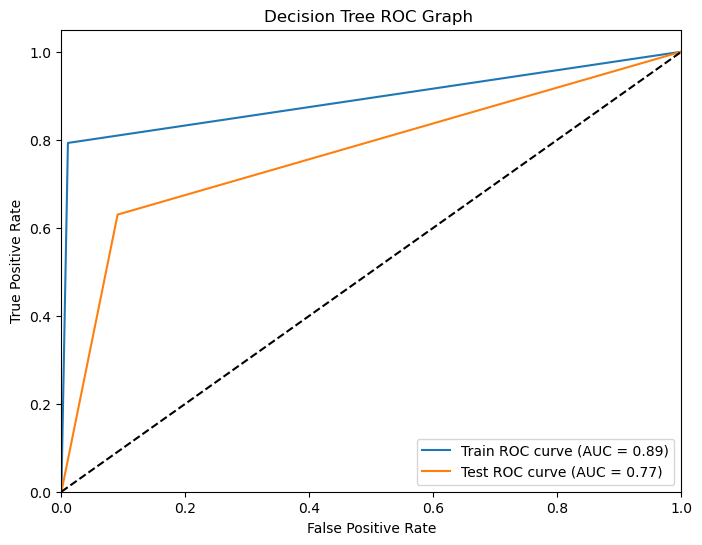

In [71]:
# Compute false positive rate, true positive rate, and thresholds
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, testpreds)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, trainpreds)

# Compute AUC-ROC for training and testing data
auc_roc_train = auc(fpr_train, tpr_train)
auc_roc_test = auc(fpr_test, tpr_test)
print(auc_roc_train)
print(auc_roc_test)

# Plot the ROC curves for training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % auc_roc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Graph ')
plt.legend(loc='lower right')
plt.show()

In [72]:
# Calculate evaluation metrics for Test
accuracy = accuracy_score(y_test, testpreds)
precision = precision_score(y_test, testpreds)
recall = recall_score(y_test, testpreds)
f1 = f1_score(y_test, testpreds)

# Create confusion matrix
confusion = confusion_matrix(y_test, testpreds)
confusion_df = pd.DataFrame(confusion, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_df)

Accuracy: 0.8588517472751009
Precision: 0.6051017113335486
Recall: 0.6298101159468997
F1 Score: 0.6172087278715521
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0        24540         2446
Actual 1         2203         3748


In [73]:
# Calculate evaluation metrics for Train
accuracy = accuracy_score(y_train, trainpreds)
precision = precision_score(y_train, trainpreds)
recall = recall_score(y_train, trainpreds)
f1 = f1_score(y_train, trainpreds)

# Create confusion matrix
confusion = confusion_matrix(y_train, trainpreds)
confusion_df = pd.DataFrame(confusion, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_df)

Accuracy: 0.9542832419959619
Precision: 0.9425774548390352
Recall: 0.7927010396774878
F1 Score: 0.8611668164949405
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0       107043         1138
Actual 1         4885        18680


###  Random Forest - Filled with Best Parameters from GridSearch

In [75]:
# Create a Random Forest classifier with specified parameters
clf = RandomForestClassifier(
    n_estimators=100,    # Number of decision trees in the forest
    criterion='gini',    # Split criterion ('gini' or 'entropy')
    max_depth=20,      # Maximum depth of the trees
    min_samples_split=2, # Minimum number of samples required to split an internal node
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
    random_state=42      # Random seed for reproducibility
)

start_time = datetime.now()
# Train the Random Forest classifier
clf.fit(X_train, y_train)
end_time = datetime.now()
training_time = end_time - start_time
print("Training time = %s" % training_time)


Training time = 0:00:22.196820


In [76]:
# Make predictions on the testing set
testpreds = clf.predict(X_test)
trainpreds = clf.predict(X_train)


0.9168045830681095
0.7957972426138846


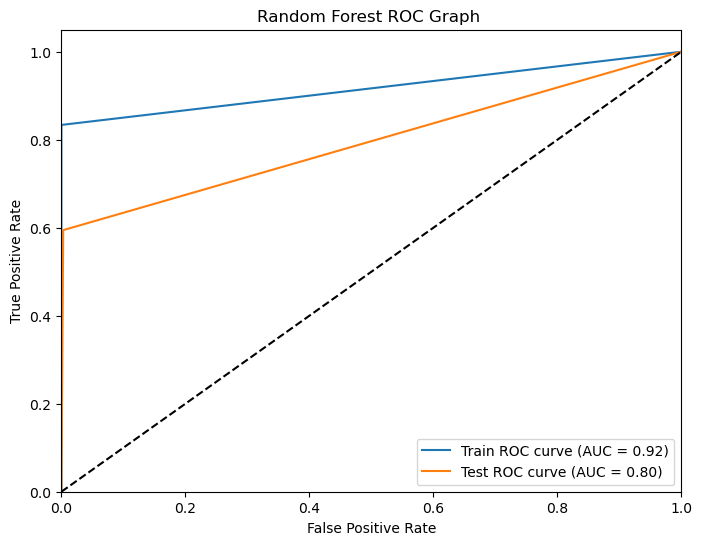

In [77]:
# Compute false positive rate, true positive rate, and thresholds
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, testpreds)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, trainpreds)

# Compute AUC-ROC for training and testing data
auc_roc_train = auc(fpr_train, tpr_train)
auc_roc_test = auc(fpr_test, tpr_test)
print(auc_roc_train)
print(auc_roc_test)

# Plot the ROC curves for training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % auc_roc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Graph ')
plt.legend(loc='lower right')
plt.show()

In [78]:
# Calculate evaluation metrics for Test
accuracy = accuracy_score(y_test, testpreds)
precision = precision_score(y_test, testpreds)
recall = recall_score(y_test, testpreds)
f1 = f1_score(y_test, testpreds)

# Create confusion matrix
confusion = confusion_matrix(y_test, testpreds)
confusion_df = pd.DataFrame(confusion, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_df)

Accuracy: 0.9243404074445153
Precision: 0.9781586950511474
Recall: 0.5945219290875483
F1 Score: 0.7395484949832776
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0        26907           79
Actual 1         2413         3538


In [79]:
# Calculate evaluation metrics for Train
accuracy = accuracy_score(y_train, trainpreds)
precision = precision_score(y_train, trainpreds)
recall = recall_score(y_train, trainpreds)
f1 = f1_score(y_train, trainpreds)

# Create confusion matrix
confusion = confusion_matrix(y_train, trainpreds)
confusion_df = pd.DataFrame(confusion, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_df)

Accuracy: 0.9702381855995628
Precision: 1.0
Recall: 0.8336091661362189
F1 Score: 0.9092550163160452
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0       108181            0
Actual 1         3921        19644


### XGBClassifier Decision Tree With Best Params



In [80]:
best_params = {'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 15,
 'n_estimators': 350,
 'subsample': 0.8}



In [81]:
start_time = datetime.now()
clf = xgb.XGBClassifier(**best_params)
clf.fit(X_train, y_train.astype(int))
end_time = datetime.now()
training_time = end_time - start_time
print("Training time = %s" % training_time)


Training time = 0:00:38.232470


In [82]:
# Make predictions on the testing set
testpreds = clf.predict(X_test)
trainpreds = clf.predict(X_train)


0.9994058985784002
0.8875700536570287


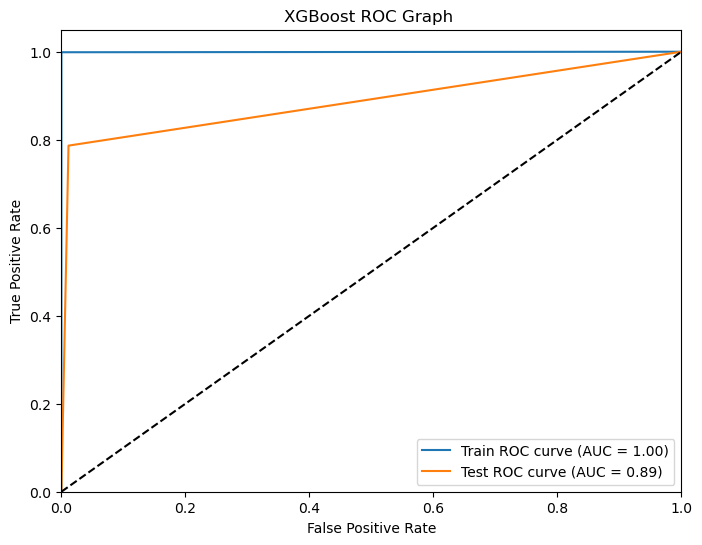

In [83]:
# Compute false positive rate, true positive rate, and thresholds
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, testpreds)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, trainpreds)

# Compute AUC-ROC for training and testing data
auc_roc_train = auc(fpr_train, tpr_train)
auc_roc_test = auc(fpr_test, tpr_test)
print(auc_roc_train)
print(auc_roc_test)

# Plot the ROC curves for training and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % auc_roc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Graph ')
plt.legend(loc='lower right')
plt.show()

In [84]:

# Calculate evaluation metrics for test
accuracy = accuracy_score(y_test, testpreds)
precision = precision_score(y_test, testpreds)
recall = recall_score(y_test, testpreds)
f1 = f1_score(y_test, testpreds)

# Create confusion matrix
confusion = confusion_matrix(y_test, testpreds)
confusion_df = pd.DataFrame(confusion, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_df)

Accuracy: 0.9520599933205817
Precision: 0.9380761523046092
Recall: 0.7865904889934465
F1 Score: 0.8556804679645371
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0        26677          309
Actual 1         1270         4681


In [85]:
# Calculate evaluation metrics for Train
accuracy = accuracy_score(y_train, trainpreds)
precision = precision_score(y_train, trainpreds)
recall = recall_score(y_train, trainpreds)
f1 = f1_score(y_train, trainpreds)

# Create confusion matrix
confusion = confusion_matrix(y_train, trainpreds)
confusion_df = pd.DataFrame(confusion, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_df)

Accuracy: 0.999787469828306
Precision: 1.0
Recall: 0.9988117971568004
F1 Score: 0.9994055454120844
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0       108181            0
Actual 1           28        23537


In [86]:
# Too Big Plot Decision Tree
# plot_tree(clf, rankdir='LR', num_trees=1)
# plt.show()

In [87]:
# Save Model
clf.save_model("model.json")

In [88]:
# Get feature importance
importance = clf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importance
print(feature_importance_df)

                            Feature  Importance
3                   NUMBER_OF_UNITS    0.087783
4                  OCCUPANCY_STATUS    0.077309
0                      CREDIT_SCORE    0.073545
14              NUMBER_OF_BORROWERS    0.068740
2     METROPOLITAN_STATISTICAL_AREA    0.066408
11                      POSTAL_CODE    0.065950
13               ORIGINAL_LOAN_TERM    0.065642
7            ORIGINAL_LOAN_TO_VALUE    0.065360
8            ORIGINAL_INTEREST_RATE    0.064896
5   ORIGINAL_COMBINED_LOAN_TO_VALUE    0.062585
6     ORIGINAL_DEBT_TO_INCOME_RATIO    0.061520
10                    PROPERTY_TYPE    0.061477
9                           CHANNEL    0.059848
12                     LOAN_PURPOSE    0.059710
1         FIRST_TIME_HOMEBUYER_FLAG    0.059227


### Creating Graph Comparing 3 ROC

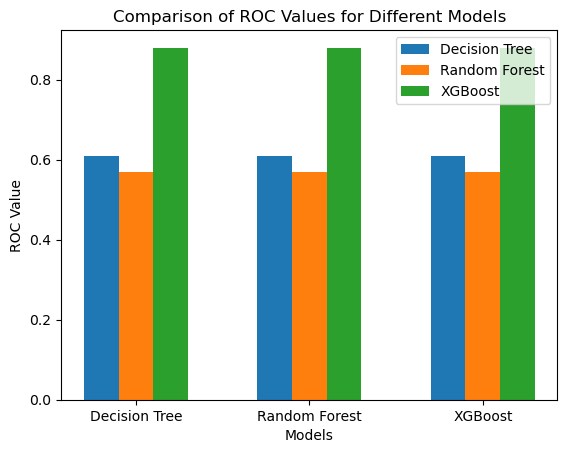

In [89]:

# Assuming you have the ROC values for three models
DTROC = [0.61]  
RFROC = [0.57]  
XGROC = [0.88]  

# Define the labels for the x-axis (e.g., different models)
x_labels = ['Decision Tree', 'Random Forest', 'XGBoost']

# Define the index positions for the bars
bar_positions = np.arange(len(x_labels))

# Define the width of each bar
bar_width = 0.2

# Plot the bars for each model
plt.bar(bar_positions, DTROC, width=bar_width, label='Decision Tree')
plt.bar(bar_positions + bar_width, RFROC, width=bar_width, label='Random Forest')
plt.bar(bar_positions + 2 * bar_width, XGROC, width=bar_width, label='XGBoost')

# Add labels and title to the plot
plt.xlabel('Models')
plt.ylabel('ROC Value')
plt.title('Comparison of ROC Values for Different Models')

# Add x-axis tick labels
plt.xticks(bar_positions + bar_width, x_labels)

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [90]:
stop

NameError: name 'stop' is not defined

### Testing the Model

In [ ]:
# Sample data
data = [
    [450, 'N', 12345.0, 1, 'I', 74,20,10,2, 'R', 'SF', 54321.0, 'P', 360.0, 1.0],
    [200, 'Y', 23456.0, 2, 'P', 115,30, 100,3, 'C', 'CO', 65432.0, 'N', 240.0, 2.0],
    [650, 'N', 34567.0, 1, 'S', 100,40, 30,4, 'B', 'CP', 76543.0, 'C', 180.0, 1.0],
    [500, 'Y', 45678.0, 2, 'I', 50,50, 40, 5,'B', 'MH', 87654.0, 'C', 300.0, 3.0],
    [500, 'Y', 47664.0, 2, 'P', 69,10, 69,6, 'C', 'SF', 48300.0, 'N', 240.0, 1.0],
]


In [ ]:
# Column names based on the given schema
columns = [
    'CREDIT_SCORE',
    'FIRST_TIME_HOMEBUYER_FLAG',
    'METROPOLITAN_STATISTICAL_AREA',
    'NUMBER_OF_UNITS', 
    'OCCUPANCY_STATUS',
    'ORIGINAL_COMBINED_LOAN_TO_VALUE',
    'ORIGINAL_DEBT_TO_INCOME_RATIO',
    'ORIGINAL_LOAN_TO_VALUE',
    'ORIGINAL_INTEREST_RATE',
    'CHANNEL',
    'PROPERTY_TYPE',
    'POSTAL_CODE',
    'LOAN_PURPOSE',
    'ORIGINAL_LOAN_TERM',
    'NUMBER_OF_BORROWERS', 
]

In [ ]:
# Create the DataFrame
test_DF = pd.DataFrame(data, columns=columns)

In [ ]:
# Label Encode

categorical_cols = ["FIRST_TIME_HOMEBUYER_FLAG", "OCCUPANCY_STATUS", "CHANNEL", "PROPERTY_TYPE", "LOAN_PURPOSE"]
for col in categorical_cols:
    test_DF[col] = label_encoder.fit_transform(test_DF[col])

In [ ]:
test_DF.head

In [ ]:
preds = clf.predict_proba(test_DF)

In [ ]:
preds

In [ ]:
#Stop

# Grid Search for best parameters


### Decision Tree

In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15,20],
    'min_samples_split': [2, 5, 10,15],
    'min_samples_leaf': [1, 2, 4,8]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# Create a Decision Tree classifier and perform grid search
dt_clf = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=kfold)

start_time = datetime.now()
dt_grid_search.fit(X_train, y_train)

end_time = datetime.now()
training_time = end_time - start_time
print("Training time = %s" % training_time)


In [ ]:
# Get the best Decision Tree model and evaluate on the test set
dt_best_model = dt_grid_search.best_estimator_
dt_predictions = dt_best_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)

In [ ]:
dt_predictions = clf.predict(X_test)
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, dt_predictions)
precision = precision_score(y_test, dt_predictions)
recall = recall_score(y_test, dt_predictions)
f1 = f1_score(y_test, dt_predictions)

# Create confusion matrix
confusion = confusion_matrix(y_test, dt_predictions)
confusion_df = pd.DataFrame(confusion, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_df)

In [ ]:
# Print the Best Parameters
best_params = dt_grid_search.best_params_

In [ ]:
best_params

In [ ]:
Stop

### Random Forest

In [ ]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10,15,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# Create a Random Forest classifier and perform grid search
rf_clf = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=kfold)
start_time = datetime.now()
rf_grid_search.fit(X_train, y_train)
end_time = datetime.now()
training_time = end_time - start_time
print("Training time = %s" % training_time)


In [ ]:
# Get the best Random Forest model and evaluate on the test set
rf_best_model = rf_grid_search.best_estimator_
rf_predictions = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

In [ ]:
rf_best_model

In [ ]:
best_params = rf_grid_search.best_params_

In [ ]:
best_params

In [ ]:
Stop

### XGboost

In [ ]:
# Specify the Parameters for XGBoost
param_grid = {
    'max_depth': [3, 5, 7,9,11,13,15],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100,150, 200,250, 300,350,400],
    'subsample': [0.8, 1.0,1.2,1.4],
    'colsample_bytree': [0.8, 1.0,1.2,1.4]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
start_time = datetime.now()
model = xgb.XGBClassifier()
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=kfold)
grid_search.fit(X_train, y_train)
end_time = datetime.now()
training_time = end_time - start_time
print("Training time = %s" % training_time)

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


In [ ]:
best_params

In [ ]:
preds = best_model.predict(X_test)


In [ ]:

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

# Create confusion matrix
confusion = confusion_matrix(y_test, preds)
confusion_df = pd.DataFrame(confusion, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_df)

In [ ]:
# Get feature importance
importance = best_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importance
print(feature_importance_df)

In [ ]:
best_model.save_model("model.json")

In [ ]:
model_xgb_2 = xgb.XGBClassifier()
model_xgb_2.load_model("model.json")